In [12]:
import sys
assert sys.version_info >= (3, 5)

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print('No GPU was detected. CNNs can be very slow without a GPU')
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to settings > Accelerator and select GPU.")
        
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU


A complete utility functionality to plot grayscale and RGB images:

In [13]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a Convolution?

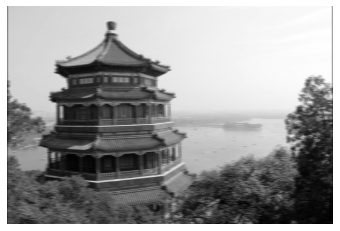

In [14]:
import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") 
plt.axis("off")
plt.show()

In [15]:
def crop(images):
    return images[150:220, 130:250]



Saving figure china_original


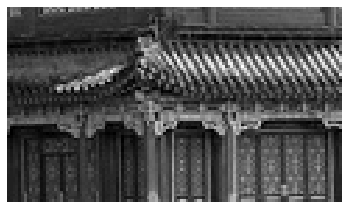

Saving figure china_vertical


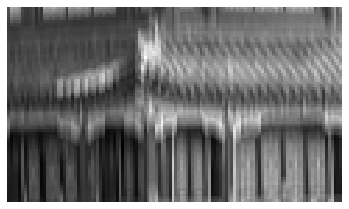

Saving figure china_horizontal


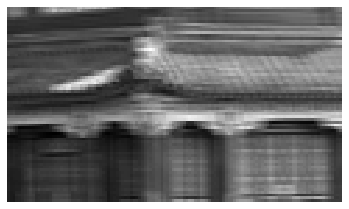

In [17]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

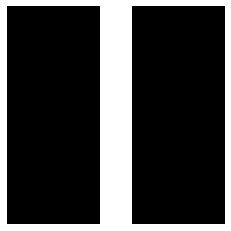

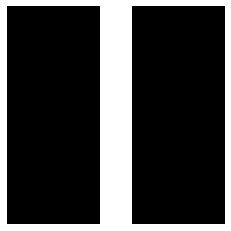

In [18]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 0])
plt.show()

## Convolution Layer

In [19]:

np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, 
                          padding="SAME", activation="relu", input_shape=outputs.shape)



In [20]:
conv_outputs = conv(images)
conv_outputs.shape


TensorShape([2, 427, 640, 2])

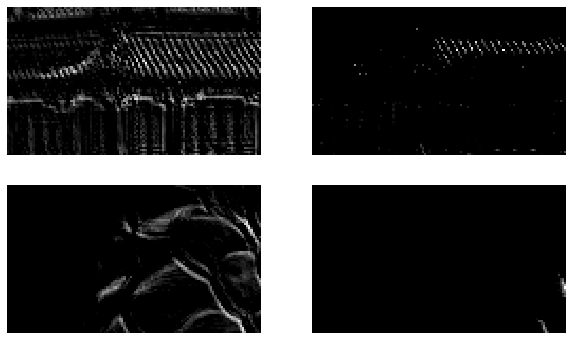

In [21]:

plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()



In [22]:
conv.set_weights([filters, np.zeros(2)])

In [23]:
conv_outputs = conv(images)
conv_outputs.shape


TensorShape([2, 427, 640, 2])

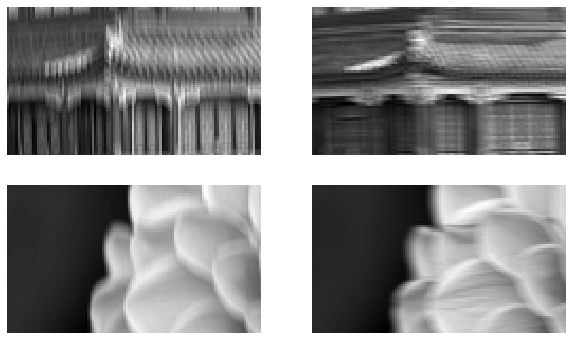

In [24]:

plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()




## VALID vs SAME padding

In [30]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [31]:
def pad_before_and_padded_size(input_size, kernel_size, stride=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size



In [32]:

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images


     

In [33]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())



## Pooling layer

### Max pooling

In [34]:
max_pool = keras.layers.MaxPool2D(pool_size=2)



In [35]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)



Saving figure china_max_pooling


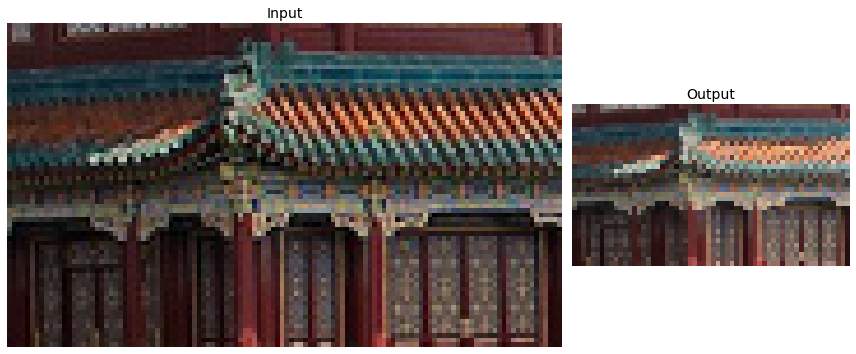

In [36]:

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()



## Depth-wise pooling

In [37]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                             ksize=(1, 1, 1, self.pool_size),
                             strides=(1, 1, 1, self.pool_size ),
                             padding=self.padding)
    
    

In [38]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape



TensorShape([2, 70, 120, 1])

In [39]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape



TensorShape([2, 70, 120, 1])

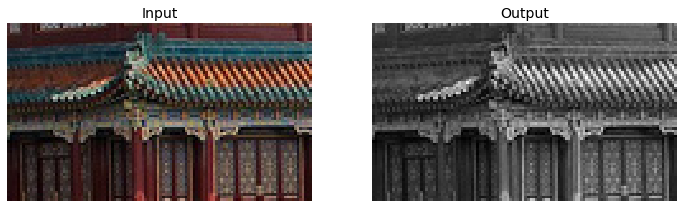

In [40]:

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()



## Average pooling

In [41]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)



In [43]:
output_avg = avg_pool(cropped_images)



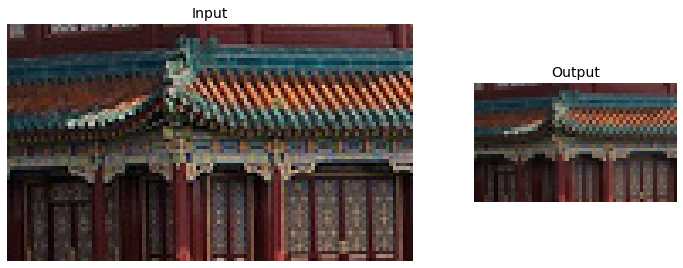

In [44]:

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()


     

## Global Average Pooling

In [46]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)



<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [48]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)



<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [49]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]


     

In [52]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, 
                       kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])



In [53]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 355s 204ms/step - loss: 0.6980 - accuracy: 0.7580 - val_loss: 0.3922 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 358s 208ms/step - loss: 0.4235 - accuracy: 0.8560 - val_loss: 0.3371 - val_accuracy: 0.8788
Epoch 3/10
1719/1719 [==============================] - 346s 201ms/step - loss: 0.3683 - accuracy: 0.8756 - val_loss: 0.3076 - val_accuracy: 0.8910
Epoch 4/10
1719/1719 [==============================] - 344s 200ms/step - loss: 0.3311 - accuracy: 0.8882 - val_loss: 0.2778 - val_accuracy: 0.8954
Epoch 5/10
1719/1719 [==============================] - 340s 198ms/step - loss: 0.3062 - accuracy: 0.8976 - val_loss: 0.2970 - val_accuracy: 0.8938
Epoch 6/10
1719/1719 [==============================] - 347s 202ms/step - loss: 0.2933 - accuracy: 0.9006 - val_loss: 0.2835 - val_accuracy: 0.8904
Epoch 7/10
1719/1719 [==============================] - 342s 199ms/step - loss: 0.2770 - accuracy: 0.9054 - val_

## ResNet-34

In [54]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                       padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
    

In [56]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                       input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))



In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

## Using a Pretrained Models

In [58]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")



102967424/102967424 [==============================] - 138s 1us/step


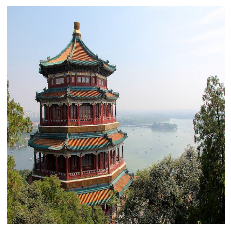

In [59]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


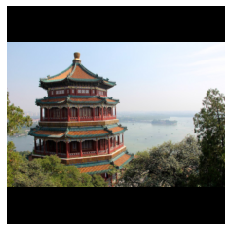

In [61]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])



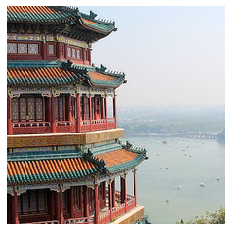

In [62]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()



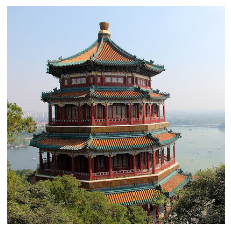

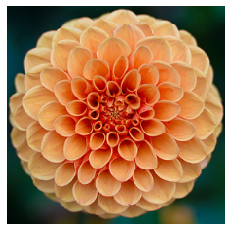

In [63]:

china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()



In [65]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)



1/1 [==============================] - 2s 2s/step


In [66]:
Y_proba.shape

(2, 1000)

In [68]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()
    
    

35363/35363 [==============================] - 0s 2us/step
Image #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.07%
 n03781244 - monastery    11.70%

Image #1
 n04522168 - vase         53.96%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning

In [70]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\badbw\tensorflow_datasets\tf_flowers\3.0.1.incompleteY40J7O\tf_flowers-train.tfrecord*...: …

Dataset tf_flowers downloaded and prepared to C:\Users\badbw\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [71]:
info.splits

{Split('train'): <SplitInfo num_examples=3670, num_shards=2>}

In [72]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [73]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [74]:
n_classes = info.features["label"].num_classes

In [75]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [78]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

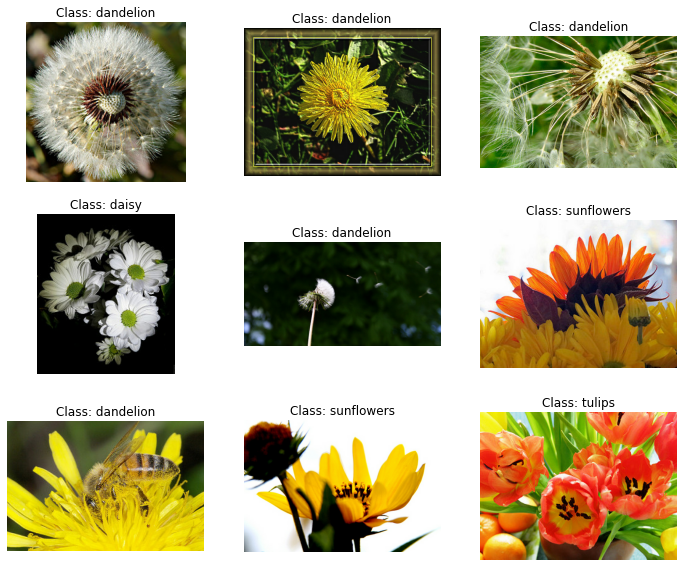

In [79]:

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()


     

In [80]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.application.xception.preprocess_input(resized_image)
    return final_image, label

In [84]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)



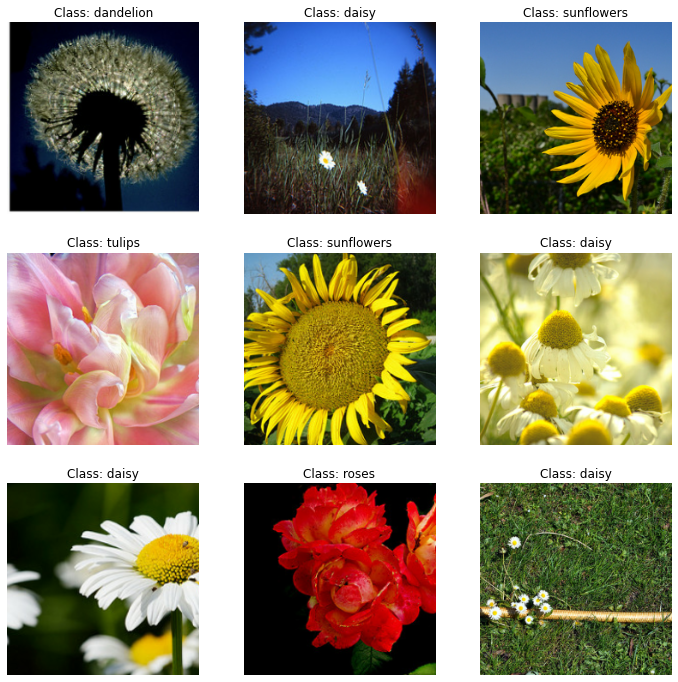

In [85]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()



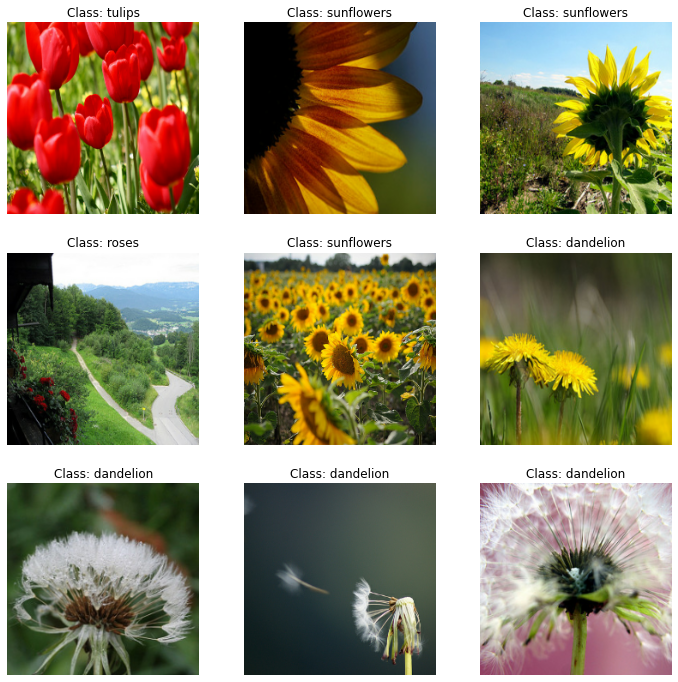

In [86]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()


    

In [87]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                 include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 90s 1us/step


In [88]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_55
13 block2_pool
14 batch_normalization_37
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_56
23 block3_pool
24 batch_normalization_38
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_57
33 block4_pool
34 batch_normalization_39
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [93]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(train_set,
                  steps_per_epoch=int(0.75 * dataset_size / batch_size),
                  validation_data=valid_set,
                  validation_steps=int(0.15 * dataset_size / batch_size),
                  epochs=5)

Epoch 1/5
86/86 [==============================] - 346s 4s/step - loss: 1.5111 - accuracy: 0.7954 - val_loss: 0.9486 - val_accuracy: 0.8585
Epoch 2/5
86/86 [==============================] - 402s 5s/step - loss: 0.6041 - accuracy: 0.8935 - val_loss: 0.8849 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 401s 5s/step - loss: 0.3704 - accuracy: 0.9179 - val_loss: 0.8639 - val_accuracy: 0.8695
Epoch 4/5
86/86 [==============================] - 400s 5s/step - loss: 0.2426 - accuracy: 0.9360 - val_loss: 0.6916 - val_accuracy: 0.8824
Epoch 5/5
86/86 [==============================] - 404s 5s/step - loss: 0.2018 - accuracy: 0.9444 - val_loss: 0.6787 - val_accuracy: 0.8750


In [94]:

for layer in base_model.layers:
    layer.trainable = True
    
optimizer = keras.optimizers.SGD(Learning_rate=0.01, momentum=0.9,
                                nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])
history = model.fit(train_set,
                   steps_per_epoch=int(0.75 * dataset_size / batch_size),
                   validation_data=valid_set,
                   validation_steps=int(0.15 * dataset_size / batch_size),
                   epochs=40)



TypeError: Learning_rate is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

## Classification and Localization

In [ ]:
base_model = keras.applcations.xception.Xception(weights="imagenet",
                                                include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_ouput = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                          outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
             loss_weights=[0.8, 0.2], # depends on what you care most about
             optimizer=optimizer, metrics=["accuracy"])

In [ ]:
def add_random_bounding_bozes(images, labels):
    fake_boxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_boxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)


In [ ]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)
          
          

## Mean Average Precision (mAP)

In [ ]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

In [ ]:

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()


     

In [ ]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape



In [ ]:

def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()


     

In [ ]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                        (height - 1) * stride + 2 * kernel_size - 1,
                        (width - 1) * stride + 2 * kernel_size -1,
                        channels))
    upscaled[:,
            kernel_size - 1:(height - 1) * stride + kernel_size:stride,
            kernel_size - 1:(width - 1) * stride + kernel_size:stride,
            :] = images
    return upscaled



In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

In [ ]:

def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()


     

In [ ]:
np.allclose(output, manual_output.numpy(), atol=1e-7)